# Problem 2:

Parameters:

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
mu0 = 4 * pi * 1e-7
#eps0 = 8.85E-12 #s^4 A^2 m^-3 kg^-1
c0 = 299792458 #m
eps0 = 1/(c0 * mu0)
hbar = 6.62606957E-34 #J s
L=60.E-2 #m
T=0.3 #unitless
lambda0 = 1064.E-9 #m
omega0 = 2.*pi*c0/lambda0 #rad/s
sigma = 4.E-23 #m^2
T1 = 250.E-6 #s
#deltom = 2.*pi*200.E9 #rad/s
deltom = 120E9 #Hz
n=1.83 #dimensionless
Vc=60.E-6 #m^3 (estimated using L*A, assumed A ~ 1cm^2)

K0=omega0*lambda0**3/(T1*4*pi**2*n**3*Vc*deltom)
#Constant part of K if we calculate sigma 
#and compare to #1.11 we're within a factor of 2*

def K(omega):
    return K0/(1+(2*(omega-omega0)/deltom)**2)

In [4]:
R, r = 0.2, 5
gammacav = (1-R)*c0/(2*L)
Ni = r*gammacav/K0
def r_om(omega):
    return r*K(omega)/K0
def Effic(eta,r):
    return 1-eta-exp(-eta*r)
def Ppk(r):
    #Peak power as a function of r
    return hbar*omega0*gammacav*Ni*(1-1./r-log(r)/r)
def taup(r,eta):
    #Pulse length as a function of r, eta
    return 1/gammacav*r*eta/(r-1-log(r))
def Uout(eta):
    #Pulse energy
    return hbar*omega0*Ni*eta

#We need to solve the transcendental Effic for eta, given r.
#Scipy uses brentq to find roots.
from scipy.optimize import brentq
#Choose frequency range:
omega = linspace(omega0-1./2*deltom,omega0+1./2*deltom,1000)
eta = zeros(len(omega))

for i in range(len(omega)):
    eta[i] = brentq(Effic,0.1,1,args=(r_om(omega[i])))

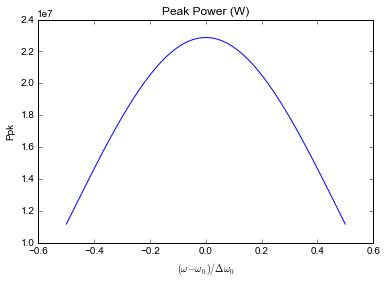

In [5]:
plot((omega-omega0)/deltom,Ppk(r_om(omega)))
ylabel('Ppk'),title('Peak Power (W)');
xlabel('$(\omega-\omega_0)/\Delta\omega_0$');

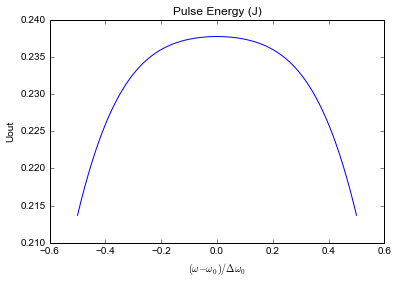

In [6]:
plot((omega-omega0)/deltom,Uout(eta))
ylabel('Uout'),title('Pulse Energy (J)');
xlabel('$(\omega-\omega_0)/\Delta\omega_0$');

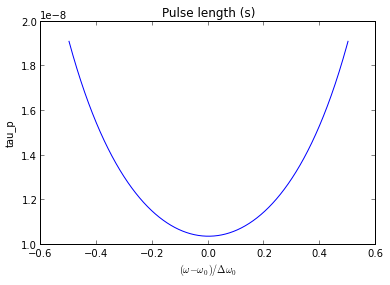

In [85]:
plot((omega-omega0)/deltom,taup(r_om(omega),eta))
ylabel('tau_p'),title('Pulse length (s)');
xlabel('$(\omega-\omega_0)/\Delta\omega_0$');

# Problem 4

First, as a test, I'm going to try an replicate the plots on #5.18

In [7]:
def RateEqns(X, t, Params):
    #return array([ -X[0]*X[1], X[1]*(X[0]-1.)]) #Linear
    return array([ -X[0]*exp(X[1]), (exp(X[0])-1.)]) #Logarithmic
    

def npk(t,r):
    #The peak intensity function, for checking our results
    #return (r-1-log(r))*(t+1)/(t+1) #Linear
    return log((r-1-log(r)))*(t+1)/(t+1) #Logarithmic
r0, Tsw = 0,0
N_0 = T*c0/(2*L)/K0 #Initial, high loss threshold

In [8]:
r=1.5 #The ratio Ni/Nmin
Bounds = [r,-23]
#Initial conditions. N starts at r. n should start tiny
t=linspace(0.,60,1.E5)


In [9]:
from scipy import integrate
X1 = integrate.odeint(RateEqns,Bounds,t,args=([r0,Tsw,],))
N,n=X1.T

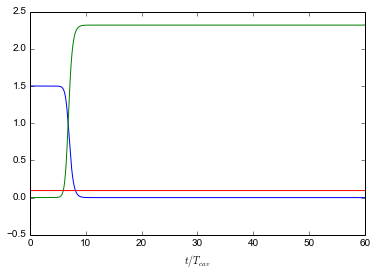

In [10]:
plot(t,N,t,exp(n),t,exp(npk(t,r)));
xlabel('$t/T_{cav}$');

Solving these using the logarithmic code works! Now to use the graded equations.

$$\frac{d\hat{N}}{d\hat{t}}=\frac{-\hat{N}\hat{n}}{r_0+(1-r_0)(1-u(\hat{t}-\hat{T}))\frac{\hat{t}}{\hat{T}}+(1-r_0)u(\hat{t}-\hat{T})}$$
$$\frac{d\hat{n}}{d\hat{t}}=\hat{n}\left[\frac{\hat{N}}{r_0+(1-r_0)(1-u(\hat{t}-\hat{T}))\frac{\hat{t}}{\hat{T}}+(1-r_0)u(\hat{t}-\hat{T})}\quad-1 \right]$$

Here $\hat{t},\hat{T},\hat{n},\hat{N}$ are nondimensionalized to $\tau_c,N_{min}$ respectively. The use of step functions is to have the threshold
linearly grade down from $r_0$ to $1$ and then remain constant rather than going lower.

In [11]:
def hstep(x):
    #Heaviside step function
    return (sign(x)+1)/2
def grading(t,Tsw,r0):
    return r0+(1-r0)*t/Tsw*(1-hstep(t-Tsw))+(1-r0)*hstep(t-Tsw)

def RateEqns(X, t, Params):
    #Coupled rate equations with graded loss
    #These solve for log(n)
    r0=Params[0]
    Tsw=Params[1]
    return array([ -X[0]*exp(X[1])/grading(t,Tsw,r0),
                    X[0]/grading(t,Tsw,r0)-1 ])

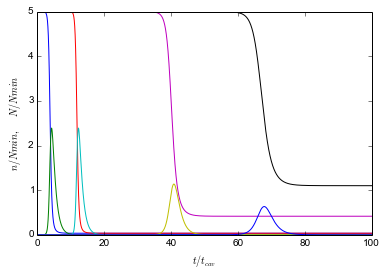

In [14]:
r=5.
r0=6.
#The ratios Ni/Nmin, N0/Nmin
Bounds = [r,-14]

TswList = [0.001,10.0,50.0,100]
#Number of cavity lifetimes to switch
for x in range(0,size(TswList)):
    Tsw=TswList[x]
    t=linspace(0,100.,1E5)
    #Non-dimensional time
    X1 = integrate.odeint(RateEqns,Bounds,t,args=([r0,Tsw,],))
    N,n=X1.T
    #infodict['message']
    figure=plot(t,N,t,exp(n))
    hold(True)
hold(False)
xlabel('$t/t_{cav}$');
ylabel('$n/Nmin,\quad N/Nmin$');
savefig('Q-Switching.png')

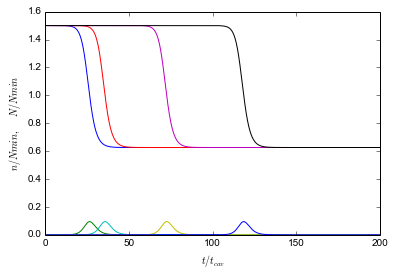

In [13]:
r=1.5
r0=2.
#The ratios Ni/Nmin, N0/Nmin
Bounds = [r,-14]

TswList = [0.001,10.0,50.0,100]
#Number of cavity lifetimes to switch
for x in range(0,size(TswList)):
    Tsw=TswList[x]
    t=linspace(0,200,2E5)
    #Non-dimensional time
    X1 = integrate.odeint(RateEqns,Bounds,t,args=([r0,Tsw,],))
    N,n=X1.T
    #infodict['message']
    figure=plot(t,N,t,exp(n))
    hold(True)
hold(False)
xlabel('$t/t_{cav}$');
ylabel('$n/Nmin,\quad N/Nmin$');

I find it suspicious that the pulse shapes have changed very little over several orders of magnitude of changes to switching time. As we discussed, for a long enough switching time the pulse should follow the switch, which isn't happenening here. I'm not sure what went wrong however, the derivation of my differential equations is attached.

Edit (5/20/2016) - The switching time didn't change, just the delay. It all makes sense